In [38]:
import numpy as np
import matplotlib.pyplot as plt
from common.layers import SigmoidWithLoss, Embedding
import collections

# Embedding layerの実装

In [7]:
class Embedding:
    def __init__(self, W):
        self.params = [W]
        self.grads = [np.zeros_like(W)]
        self.idx = None

    def forward(self, idx):
        W, = self.params
        self.idx = idx
        out = W[idx]
        return out

    def backward(self, dout):
        dW, = self.grads
        dW[...] = 0

        for i, word_idx in enumerate(self.idx):
            dW[word_idx] += dout[i] # もしくは np.add.at(dw, word_idx, dout)
            return None
            

In [6]:
# ミュータブルの確認

a = np.array([1, 2])
list_a = [a]

a, = list_a

a[...] = 0


list_a

[array([0, 0])]

In [66]:
class EmbeddingDot:
    def __init__(self, W):
        self.embed = Embedding(W)
        self.params = self.embed.params
        self.grads = self.embed.grads
        self.cache = None

    def forward(self, h, idx):
        target_W = self.embed.forward(idx)
        out = np.sum(target_W * h, axis=1)

        self.cache = (h, target_W)
        return out

    def backward(self, dout):
        h, target_W = self.cache
        dout = dout.reshape(dout.shape[0], 1)
        dtarget_W = dout * h
        self.embed.backward(dtarget_W)
        dh = dout * target_W
        return dh

# Negative Samplingの実装

In [67]:
class UnigramSampler:
    def __init__(self, corpus, power, sample_size):
        self.sample_size = sample_size
        self.vocab_size = None
        self.word_p = None

        counts = collections.Counter()
        for word_id in corpus:
            counts[word_id] += 1

        vocab_size = len(counts)
        self.vocab_size = vocab_size

        self.word_p = np.zeros(vocab_size)
        for i in range(vocab_size):
            self.word_p[i] = counts[i]

        self.word_p = np.power(self.word_p, power)
        self.word_p /= np.sum(self.word_p)

    def get_negative_sample(self, target):
        batch_size = target.shape[0]

        if not GPU:
            negative_sample = np.zeros((batch_size, self.sample_size), dtype=np.int32)

            for i in range(batch_size):
                p = self.word_p.copy()
                target_idx = target[i]
                p[target_idx] = 0
                p /= p.sum()
                negative_sample[i, :] = np.random.choice(self.vocab_size, size=self.sample_size, replace=False, p=p)
        else:
            # GPU(cupy）で計算するときは、速度を優先
            # 負例にターゲットが含まれるケースがある
            negative_sample = np.random.choice(self.vocab_size, size=(batch_size, self.sample_size),
                                               replace=True, p=self.word_p)

        return negative_sample

In [99]:
class NegativesamplingLoss:
    def __init__(self, W, corpus, power=0.75, sample_size=5):
        self.sample_size = sample_size
        self.sampler = UnigramSampler(corpus, power, sample_size)
        self.loss_layers = [SigmoidWithLoss() for _ in range(sample_size + 1)] # 正例 1 + 負例 5
        self.embed_dot_layers = [EmbeddingDot(W) for _ in range(sample_size + 1)]
        
        self.params, self.grads  = [], []
        for layer in self.embed_dot_layers:
            self.params += layer.params
            self.grads += layer.grads

    def forward(self, h, target):
        batch_size = target.shape[0]
        negative_sample = self.sampler.get_negative_sample(target)

        # 正例 最初のレイヤーを使用
        score = self.embed_dot_layers[0].forward(h, target)
        correct_label = np.ones(batch_size, dtype=np.int32)
        loss = self.loss_layers[0].forward(score, correct_label)

        # 負例
        negative_label = np.zeros(batch_size, dtype=np.int32)
        for i in range(self.sample_size):
            negative_target = negative_sample[:, i]
            score = self.embed_dot_layers[1 + i].forward(h, negative_target)
            loss += self.loss_layers[1 + i].forward(score, negative_label)

        return loss


    def backward(self, dout=1):
        dh = 0 # 初期化
        for l0, l1 in zip(self.loss_layers, self.embed_dot_layers):
            dscore = l0.backward(dout)
            dh += l1.backward(dscore)

        return dh

# CBOWモデルの実装

In [100]:
class CBOW:
    def __init__(self, vocab_size, hidden_size, window_size, corpus):
        V, H = vocab_size, hidden_size

        # 重みの初期化
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(V, H).astype('f')


        # レイヤー
        self.in_layers = []

        # input側のEmbding layers
        for i in range(window_size * 2):
            layer = Embedding(W_in)
            self.in_layers.append(layer)
            
        # loss側のlayers
        self.ns_loss = NegativesamplingLoss(W_out, corpus, power=0.75, sample_size=5)

        # 勾配とパラメータをまとめる
        self.params, self.grads = [], []
        self.layers = self.in_layers + [self.ns_loss] # params, gradsナンバ変数を持つinput, loss layers
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

        self.words_vecs = W_in
        

    def forward(self, contexts, target):
        h = 0
        for i, layer in enumerate(self.in_layers):
            h += layer.forward(contexts[:, i]) # (ex, window_size=1の場合、contextの1列目と2列目の合計
        h *= 1 / len(self.in_layers)
        loss = self.ns_loss.forward(h, target)
        return loss

    def backward(self, dout=1):
        dout = self.ns_loss.backward(dout)
        dout /= len(self.in_layers)
        for layer in self.in_layers:
            layer.backward(dout)
        return None

# class CBOW:
#     def __init__(self, vocab_size, hidden_size, window_size, corpus):
#         V, H = vocab_size, hidden_size

#         # 重みの初期化
#         W_in = 0.01 * np.random.randn(V, H).astype('f')
#         W_out = 0.01 * np.random.randn(V, H).astype('f')

#         # レイヤの生成
#         self.in_layers = []
#         for i in range(2 * window_size):
#             layer = Embedding(W_in)  # Embeddingレイヤを使用
#             self.in_layers.append(layer)
#         self.ns_loss = NegativeSamplingLoss(W_out, corpus, power=0.75, sample_size=5)

#         # すべての重みと勾配をリストにまとめる
#         layers = self.in_layers + [self.ns_loss]
#         self.params, self.grads = [], []
#         for layer in layers:
#             self.params += layer.params
#             self.grads += layer.grads

#         # メンバ変数に単語の分散表現を設定
#         self.word_vecs = W_in

#     def forward(self, contexts, target):
#         h = 0
#         for i, layer in enumerate(self.in_layers):
#             h += layer.forward(contexts[:, i])
#         h *= 1 / len(self.in_layers)
#         loss = self.ns_loss.forward(h, target)
#         return loss

#     def backward(self, dout=1):
#         dout = self.ns_loss.backward(dout)
#         dout *= 1 / len(self.in_layers)
#         for layer in self.in_layers:
#             layer.backward(dout)
#         return None

In [101]:
from common import config
from common.np import *
import pickle
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import create_contexts_target, to_cpu, to_gpu
from hidden_others.dataset import ptb

| epoch 1 |  iter 1 / 9295 | time 0[s] | loss 4.16
| epoch 1 |  iter 21 / 9295 | time 1[s] | loss 4.16
| epoch 1 |  iter 41 / 9295 | time 3[s] | loss 4.15
| epoch 1 |  iter 61 / 9295 | time 4[s] | loss 4.12
| epoch 1 |  iter 81 / 9295 | time 5[s] | loss 4.05
| epoch 1 |  iter 101 / 9295 | time 7[s] | loss 3.92
| epoch 1 |  iter 121 / 9295 | time 8[s] | loss 3.78
| epoch 1 |  iter 141 / 9295 | time 10[s] | loss 3.62
| epoch 1 |  iter 161 / 9295 | time 11[s] | loss 3.47
| epoch 1 |  iter 181 / 9295 | time 13[s] | loss 3.35
| epoch 1 |  iter 201 / 9295 | time 14[s] | loss 3.24
| epoch 1 |  iter 221 / 9295 | time 16[s] | loss 3.15
| epoch 1 |  iter 241 / 9295 | time 18[s] | loss 3.08
| epoch 1 |  iter 261 / 9295 | time 19[s] | loss 3.01
| epoch 1 |  iter 281 / 9295 | time 21[s] | loss 2.96
| epoch 1 |  iter 301 / 9295 | time 22[s] | loss 2.93
| epoch 1 |  iter 321 / 9295 | time 24[s] | loss 2.88
| epoch 1 |  iter 341 / 9295 | time 25[s] | loss 2.84
| epoch 1 |  iter 361 / 9295 | time 27[s]

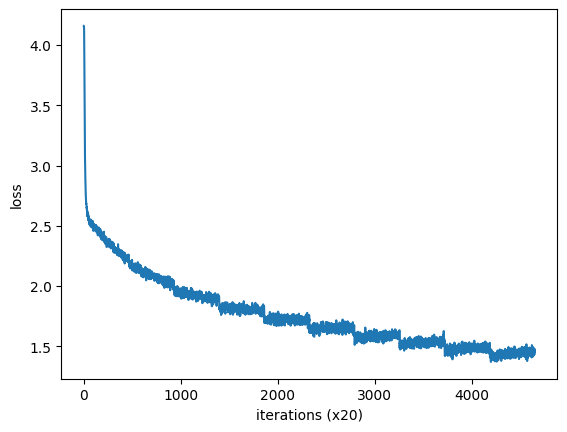

In [103]:
# ハイパーパラメータ
window_size = 5
hidden_size = 100
batch_size = 100
max_epoch = 10

# データ準備
corpus, word_to_id, id_to_word = ptb.load_data('train')
vocab_size = len(word_to_id)


contexts, target = create_contexts_target(corpus, window_size)
if config.GPU:
    contexts, target = to_gpu(contexts), to_gpu(target)

#　model
model = CBOW(vocab_size, hidden_size, window_size, corpus)
optimizer = Adam()
trainer = Trainer(model, optimizer)

# fit
trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [104]:
# 後ほど利用できるように、必要なデータを保存
word_vecs = model.word_vecs
if config.GPU:
    word_vecs = to_cpu(word_vecs)
params = {}
params['word_vecs'] = word_vecs.astype(np.float16)
params['word_to_id'] = word_to_id
params['id_to_word'] = id_to_word
pkl_file = 'cbow_params.pkl'  # or 'skipgram_params.pkl'
with open(pkl_file, 'wb') as f:
    pickle.dump(params, f, -1)

AttributeError: 'CBOW' object has no attribute 'word_vecs'

In [113]:
# 保存したモデルの評価
from common.util import most_similar

pickle_file = 'cbow_params.pkl'

with open(pickle_file, 'rb') as f:
    params = pickle.load(f)
    word_vecs = params['word_vecs']
    word_to_id = params['word_to_id']
    id_to_word = params['id_to_word']

querys = ['you', 'year', 'car', 'toyota']
for query in querys:
    most_similar(query, word_to_id, id_to_word, word_vecs, top=5)



[query] you
 we: 0.7333984375
 i: 0.68994140625
 your: 0.6162109375
 they: 0.59228515625
 us: 0.56103515625

[query] year
 month: 0.84912109375
 week: 0.79052734375
 summer: 0.77587890625
 spring: 0.75634765625
 decade: 0.705078125

[query] car
 window: 0.6103515625
 luxury: 0.59912109375
 scorpio: 0.58349609375
 cars: 0.57958984375
 truck: 0.5751953125

[query] toyota
 seita: 0.6328125
 nec: 0.60986328125
 nissan: 0.6005859375
 engines: 0.59130859375
 honda: 0.5908203125


In [114]:
from common.util import analogy
analogy('king', 'man', 'queen', word_to_id, id_to_word, word_vecs)


[analogy] king:man = queen:?
 a.m: 5.9921875
 woman: 5.421875
 hacker: 4.78515625
 naczelnik: 4.6796875
 mother: 4.65234375


In [115]:
analogy('take', 'took', 'go', word_to_id, id_to_word, word_vecs)


[analogy] take:took = go:?
 went: 4.62109375
 were: 4.359375
 're: 4.33203125
 came: 4.27734375
 a.m: 4.07421875


In [116]:
analogy('car', 'cars', 'child', word_to_id, id_to_word, word_vecs)


[analogy] car:cars = child:?
 a.m: 7.59765625
 rape: 5.79296875
 daffynition: 5.28125
 incest: 5.10546875
 children: 5.01953125


In [118]:
analogy('good', 'best', 'bad', word_to_id, id_to_word, word_vecs)


[analogy] good:best = bad:?
 rest: 4.08984375
 region: 3.84765625
 moment: 3.83984375
 cubans: 3.59765625
 same: 3.5703125
